<a href="https://colab.research.google.com/github/2653319/book-example/blob/main/%E4%BD%BF%E7%94%A8%E7%A5%9E%E7%B6%93%E7%B6%B2%E7%B5%A1%E9%A0%90%E6%B8%AC%E5%A4%AA%E9%99%BD%E9%BB%91%E5%AD%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_3_Sunspots_CNN_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 未分級實驗室：使用神經網絡預測太陽黑子

在課程的這一點上，您應該能夠探索不同的網絡架構進行預測。在前幾週，您已經使用 DNN、RNN 和 CNN 來構建這些不同的模型。在本課程的最後練習實驗室中，您將嘗試另一種配置，它是所有這些類型網絡的組合：數據窗口將通過卷積，然後是堆疊的 LSTM，然後是堆疊的密集層。看看這是否會改善結果，或者您可以選擇更簡單的模型。

## Imports

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

## Utilities

In [ ]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

In [ ]:
# Download the Dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2022-04-30 14:11:13--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.253.63.128, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.002s  

2022-04-30 14:11:13 (36.2 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



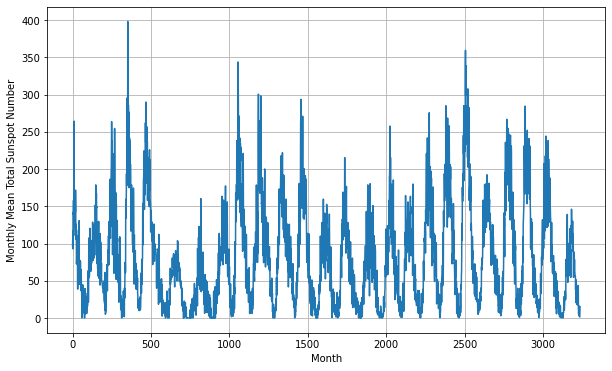

In [ ]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

## Split the Dataset

In [ ]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## 準備特徵和標籤

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

正如講座中提到的，如果你的結果不好，你可以嘗試在這裡調整參數，看看模型是否會學習得更好。

In [ ]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
for a,b in train_set.take(1):
  print(a.shape) #x值
  print(b.shape) #y值

(32, 30)
(32,)


In [ ]:
for a in train_set.take(1):
  print(a[0].shape) #x值
  print(a[1].shape) #y值

(32, 30)
(32,)



## 構建模型

您之前已經看過這些圖層，下面是它們組合時的樣子。

In [ ]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

## 調整學習率

像往常一樣，您需要選擇一個最佳學習率。

In [ ]:
# Get initial weights
init_weights = model.get_weights()

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 15s 9ms/step - loss: 61.0842 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 9ms/step - loss: 54.2615 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 8ms/step - loss: 47.8140 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 1s 8ms/step - loss: 43.0135 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 8ms/step - loss: 39.2431 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 8ms/step - loss: 36.0944 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 1s 9ms/step - loss: 33.5584 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 1s 9ms/step - loss: 31.5497 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 8ms/step - loss: 29.8632 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 1s 8ms/step - loss: 28.3105 - lr: 2.8184e-08
Epoch 11/100
93/93

(1e-08, 0.001, 0.0, 100.0)

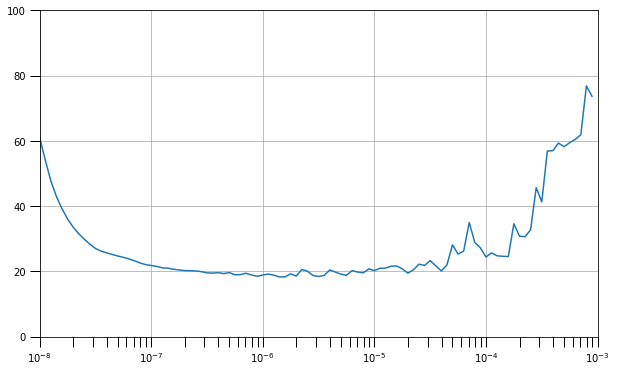

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below but feel free to increase it if you want. Laurence got his results in the lectures after 500.

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [ ]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 4s 9ms/step - loss: 30.1056 - mae: 30.6002
Epoch 2/100
93/93 [==============================] - 1s 9ms/step - loss: 22.3801 - mae: 22.8746
Epoch 3/100
93/93 [==============================] - 1s 9ms/step - loss: 20.6893 - mae: 21.1826
Epoch 4/100
93/93 [==============================] - 1s 9ms/step - loss: 20.6365 - mae: 21.1311
Epoch 5/100
93/93 [==============================] - 1s 9ms/step - loss: 20.0064 - mae: 20.4994
Epoch 6/100
93/93 [==============================] - 1s 9ms/step - loss: 19.3307 - mae: 19.8247
Epoch 7/100
93/93 [==============================] - 1s 9ms/step - loss: 19.5312 - mae: 20.0236
Epoch 8/100
93/93 [==============================] - 1s 9ms/step - loss: 19.3850 - mae: 19.8769
Epoch 9/100
93/93 [==============================] - 1s 9ms/step - loss: 18.9730 - mae: 19.4651
Epoch 10/100
93/93 [==============================] - 1s 9ms/step - loss: 18.5206 - mae: 19.0127
Epoch 11/100
93/93 [===================

您可以可視化訓練並查看損失和 MAE 是否仍呈下降趨勢。

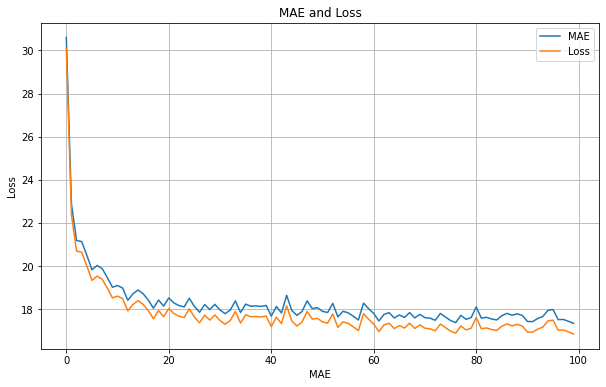

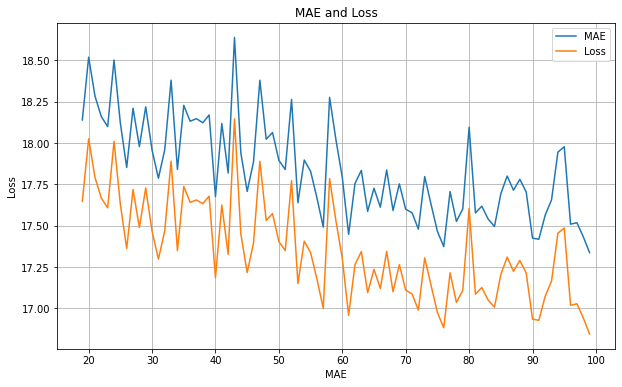

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## 模型預測

和以前一樣，您可以獲得驗證集時間範圍的預測併計算指標。

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

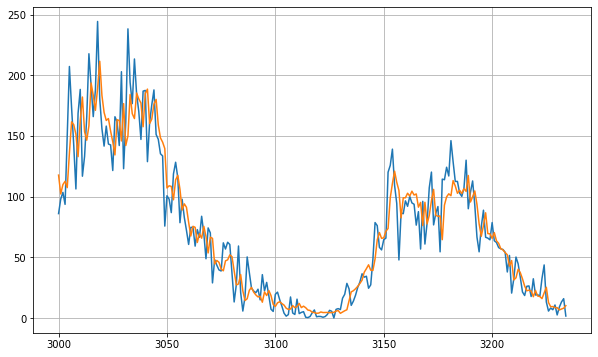

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.369615


## Wrap Up

本課程的最終練習實驗室到此結束！您實現了一個由 CNN、RNN 和 DNN 組成的深度而復雜的架構。您將使用您在本課程中開發的技能來完成最終作業。保持！

## Optional

在此可選部分中，您將了解另一種動態設置學習率的方法。您可能已經註意到，長時間的訓練對損失和指標產生的變化越來越少。您可以運行下面的單元格再次觀察。

In [ ]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=10)

Epoch 1/10
93/93 [==============================] - 4s 9ms/step - loss: 16.4973 - mae: 16.9862
Epoch 2/10
93/93 [==============================] - 1s 9ms/step - loss: 16.4886 - mae: 16.9760
Epoch 3/10
93/93 [==============================] - 1s 9ms/step - loss: 16.4176 - mae: 16.9065
Epoch 4/10
93/93 [==============================] - 1s 9ms/step - loss: 16.4193 - mae: 16.9083
Epoch 5/10
93/93 [==============================] - 1s 9ms/step - loss: 16.4252 - mae: 16.9134
Epoch 6/10
93/93 [==============================] - 1s 9ms/step - loss: 16.4298 - mae: 16.9184
Epoch 7/10
93/93 [==============================] - 1s 9ms/step - loss: 16.4007 - mae: 16.8891
Epoch 8/10
93/93 [==============================] - 1s 9ms/step - loss: 16.4548 - mae: 16.9428
Epoch 9/10
93/93 [==============================] - 1s 9ms/step - loss: 16.4232 - mae: 16.9122
Epoch 10/10
93/93 [==============================] - 1s 9ms/step - loss: 16.4510 - mae: 16.9408


在某些時候，當模型已經學習了一段時間時，您設置的靜態學習率可能不再是最佳的。您可能希望進一步減少它以查看更好的改進。一種方法是讓你的訓練循環逐漸衰減每個 epoch 的學習率。您可以傳入一個類似於之前為學習率調度程序所做的 lambda 函數，或使用 [ExponentialDecay()](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/指數衰減）。這是來自 Keras API 的內置調度程序。這會衰減此函數定義的學習率：

```
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

下面看看它是如何使用的。

In [ ]:
# Set the 初始學習率
initial_learning_rate=1e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=40)

Epoch 1/40
93/93 [==============================] - 4s 9ms/step - loss: 16.4197 - mae: 16.9091
Epoch 2/40
93/93 [==============================] - 1s 9ms/step - loss: 16.4428 - mae: 16.9315
Epoch 3/40
93/93 [==============================] - 1s 9ms/step - loss: 16.4147 - mae: 16.9034
Epoch 4/40
93/93 [==============================] - 1s 9ms/step - loss: 16.3888 - mae: 16.8764
Epoch 5/40
93/93 [==============================] - 1s 9ms/step - loss: 16.4069 - mae: 16.8960
Epoch 6/40
93/93 [==============================] - 1s 9ms/step - loss: 16.4447 - mae: 16.9320
Epoch 7/40
93/93 [==============================] - 1s 9ms/step - loss: 16.3975 - mae: 16.8854
Epoch 8/40
93/93 [==============================] - 1s 9ms/step - loss: 16.4036 - mae: 16.8920
Epoch 9/40
93/93 [==============================] - 1s 9ms/step - loss: 16.3724 - mae: 16.8607
Epoch 10/40
93/93 [==============================] - 1s 9ms/step - loss: 16.4055 - mae: 16.8934
Epoch 11/40
93/93 [==============================

現在通過獲取預測和計算指標來查看結果。

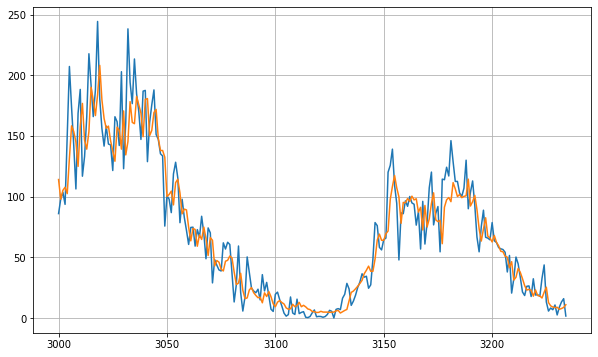

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
# Compute the MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.166837